In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
import tensorflow.compat.v1 as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class SOM(): 

    def __init__(self,m,n,dim,learning_rate_som = 0.5, radius_factor = 1.3):
        
        self.m = m
        self.n = n
        self.dim = dim
        self.map = tf.Variable(tf.random.uniform(shape=[m*n,dim],minval=0,maxval=1,seed=2))
        self.location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
        self.alpha = learning_rate_som
        self.sigma = max(m,n)*1.1

    def _neuron_locations(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def getmap(self): return self.map
    def getlocation(self): return self.bmu_locs

    def feedforward(self, input):
    
        self.input = input
        self.squared_distance = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.map, axis=0),tf.expand_dims(self.input, axis=1)), 2), 2)
        self.bmu_indices = tf.argmin(self.squared_distance, axis=1)
        self.bmu_locs = tf.reshape(tf.gather(self.location_vects, self.bmu_indices), [-1, 2])

    def backprop(self,iter,num_epoch):

        # Update the weigths 
        radius = tf.subtract(self.sigma,
                                tf.multiply(iter,
                                            tf.divide(tf.cast(tf.subtract(self.alpha, 1), tf.float32),
                                                    tf.cast(tf.subtract(num_epoch, 1), tf.float32))))

        alpha = tf.subtract(self.alpha,
                            tf.multiply(iter,
                                            tf.divide(tf.cast(tf.subtract(self.alpha, 1), tf.float32),
                                                      tf.cast(tf.subtract(num_epoch, 1), tf.float32))))

        self.bmu_distance_squares = tf.reduce_sum(
                tf.pow(tf.subtract(
                    tf.expand_dims(self.location_vects, axis=0),
                    tf.expand_dims(self.bmu_locs, axis=1)), 2), 
            2)

        self.neighbourhood_func = tf.exp(tf.divide(tf.negative(tf.cast(
                self.bmu_distance_squares, "float32")), tf.multiply(
                tf.square(tf.multiply(radius, 0.08)), 2)))

        self.learning_rate_op = tf.multiply(self.neighbourhood_func, alpha)
        
        self.numerator = tf.reduce_sum(
            tf.multiply(tf.expand_dims(self.learning_rate_op, axis=-1),
            tf.expand_dims(self.input, axis=1)), axis=0)

        self.denominator = tf.expand_dims(
            tf.reduce_sum(self.learning_rate_op,axis=0) + float(1e-20), axis=-1)

        self.new_weights = tf.div(self.numerator, self.denominator)
        self.update = tf.assign(self.map, self.new_weights)

        return self.update
    

In [21]:
data = pd.read_csv("b.csv")

data_ = data.iloc[:, [ 12]]


mapping = {'False': 0, 'True': 1}

data_ = data_.replace({False: 0, True: 1, 'nan' : 0})


data_ -= data_.min()
data_ /= data_.max()

print(data_.head())
# print(len(list(set(data["Primary Type"].values))))



v_data = np.nan_to_num(np.array(data_.values)[0:4096, :])

       Ward
0  0.346939
1  0.673469
2  0.265306
3  0.081633
4  0.755102


In [22]:

colors = v_data

In [29]:

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(v_data)
colors = pca.fit_transform(v_data)


In [17]:

print(set(np.array(data["Primary Type"].values)[0:4096]))
names = np.array(data["Primary Type"].values)


{'INTIMIDATION', 'CRIMINAL DAMAGE', 'GAMBLING', 'CONCEALED CARRY LICENSE VIOLATION', 'NARCOTICS', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION', 'OTHER OFFENSE', 'ASSAULT', 'CRIM SEXUAL ASSAULT', 'WEAPONS VIOLATION', 'ROBBERY', 'OBSCENITY', 'STALKING', 'DECEPTIVE PRACTICE', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'THEFT', 'MOTOR VEHICLE THEFT', 'ARSON', 'OFFENSE INVOLVING CHILDREN', 'CRIMINAL TRESPASS', 'BURGLARY', 'NON-CRIMINAL', 'KIDNAPPING', 'INTERFERENCE WITH PUBLIC OFFICER', 'BATTERY', 'SEX OFFENSE'}


In [ ]:
# hyper parameter
dim  = 100
SOM_layer = SOM(dim, dim, 1)
num_epoch = 300
batch_size = 4096


import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()

# create the graph
x = tf.placeholder(shape=[batch_size, 1],dtype=tf.float32)
current_iter = tf.placeholder(shape=[],dtype=tf.float32)

# graph
SOM_layer.feedforward(x)
map_update=SOM_layer.backprop(current_iter,num_epoch)

# session
with tf.Session() as sess: 

    sess.run(tf.global_variables_initializer())

    # start the training
    for iter in range(num_epoch):
        for current_train_index in range(0, len(colors),batch_size):
            currren_train = colors[current_train_index:current_train_index+batch_size]
            sess.run(map_update,feed_dict={x:currren_train,current_iter:iter})
            
            
        if iter % 10 == 0: print("-- num_iter: ", iter, " --")
        
        
    # get the trained map and normalize
    trained_map = sess.run(SOM_layer.getmap()).reshape(dim,dim,1)
    trained_map[:,:,0] = (trained_map[:,:,0]-trained_map[:,:,0].min())/(trained_map[:,:,0].max()-trained_map[:,:,0].min())
   # trained_map[:,:,1] = (trained_map[:,:,1]-trained_map[:,:,1].min())/(trained_map[:,:,1].max()-trained_map[:,:,1].min())
   # trained_map[:,:,2] = (trained_map[:,:,2]-trained_map[:,:,2].min())/(trained_map[:,:,2].max()-trained_map[:,:,2].min())

    # after training is done get the cloest vector
    locations = sess.run(SOM_layer.getlocation(), feed_dict={x:colors})
    
    
    plt.figure(figsize=(20, 10))
    plt.imshow(trained_map.astype(float))
    

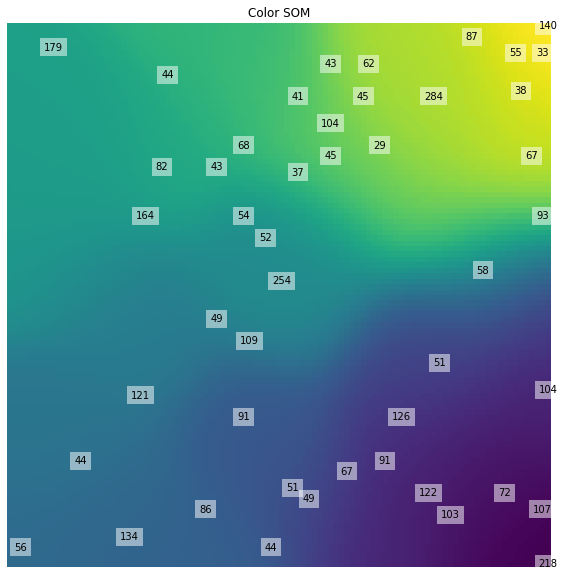

In [74]:
    plt.figure(figsize=(20, 10))
    plt.imshow(trained_map.astype(float))
    
    count_points = []
    b = tuple(tuple(i) for i in locations)
    for point in list(set(tuple(i) for i in locations)):
        count_points.append(b.count(point))
    
    for i, m in enumerate(list(set(tuple(i) for i in locations))):
        plt.text(m[1], m[0], count_points[i], ha='center', va='center',bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
    plt.axis('off')
    plt.title('Color SOM')
    plt.show()
    plt.close('all')

In [72]:
# Plot

plt.figure(figsize=(30, 20))
plt.imshow(image_grid)
plt.title('Color SOM')


    
p = {'OTHER OFFENSE':'black',
     'CRIM SEXUAL ASSAULT':'blue',
     'MOTOR VEHICLE THEFT':'darkblue',
     'CRIMINAL TRESPASS':'skyblue', 
     'OFFENSE INVOLVING CHILDREN':'blue',
     'INTERFERENCE WITH PUBLIC OFFICER':'violet',
     'NARCOTICS':'green',
     'ASSAULT':'red',
     'BURGLARY':'cyan', 
     'LIQUOR LAW VIOLATION':'violet', 
     'ROBBERY':'yellow',
     'CRIMINAL DAMAGE':'white',
     'SEX OFFENSE':'darkgrey', 
     'BATTERY':'grey',
     'THEFT':'lightgrey',
     'DECEPTIVE PRACTICE':'black', 
     'WEAPONS VIOLATION':'blue', 
     'PROSTITUTION': 'darkblue' }

for i, m in enumerate(mapped):
    plt.text(m[1], m[0], names[i], ha='center', va='center',
             bbox=dict(facecolor=p[names[i]], alpha=0.5, lw=0))

plt.show()


NameError: name 'image_grid' is not defined

<Figure size 2160x1440 with 0 Axes>